In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

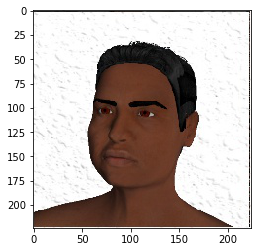

In [3]:
#读取图像
img0 = cv2.imread('man.jpg')
img = img0[:,:,::-1] # 必须为 ::-1
plt.imshow(img) 
plt.show()

In [4]:
# 提取68个特征点
def get_landmarks68(img):
    rects = detector(img, 1)
    if len(rects) == 0:
        return -1
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
# 注释68个标记点
def annotate_landmarks68(im):
    img = im.copy()
    landmarks68=get_landmarks68(img)
    for idx, point in enumerate(landmarks68):
        pos = (point[0, 0], point[0, 1])
        #cv2.putText(img, str(idx), pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.4,color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

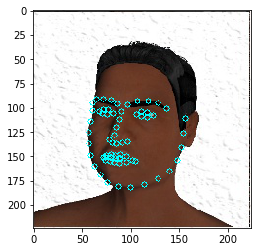

In [5]:
a=annotate_landmarks68(img)
plt.imshow(a)
plt.show()

In [6]:
# 手动构建7点人脸3D模型
def model_3D():
    '''
    手动构建7点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型7点矩阵
    '''
    model_points = np.array([
        (-225.0, 170.0, -135.0),  # 左眼左眼角
        (-75.0, 170.0, -135.0),  # 左眼右眼角，自己定的
        (75.0, 170.0, -135.0),  # 右眼左眼角，自己定的
        (225.0, 170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (-150.0, -150.0, -125.0),  # 左嘴角
        (150.0, -150.0, -125.0)  # 右嘴角
    ])
    return model_points

[[-225.  170. -135.]
 [ -75.  170. -135.]
 [  75.  170. -135.]
 [ 225.  170. -135.]
 [   0.    0.    0.]
 [-150. -150. -125.]
 [ 150. -150. -125.]]


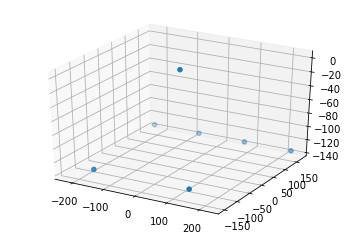

In [7]:
model_points=model_3D()
print(model_points)
ax = plt.subplot(111, projection='3d')
ax.scatter(model_points.T[0],model_points.T[1],model_points.T[2])
plt.show()

In [8]:
# 获取最大的人脸
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [9]:
# dlib获取人脸7特征点
def get_landmark7(img):
    '''
    用dlib获取人脸7个特征点
    :param img: 输入图片
    :return: 人脸7特征点矩阵(0, landmark7)，若未检测到人脸，返回(-1，None)
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return -1, None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark7 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(39).x, landmark68.part(39).y),  # 左眼右眼角
        (landmark68.part(42).x, landmark68.part(42).y),  # 右眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(48).x, landmark68.part(48).y),  # 左嘴角
        (landmark68.part(54).x, landmark68.part(54).y)  # 右嘴角
    ], dtype="double")
    return 0, landmark7

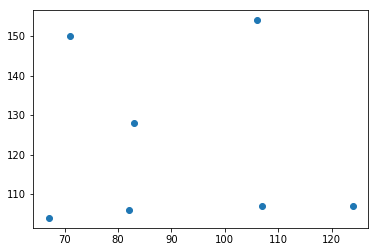

In [10]:
image_points=get_landmark7(img)[1]
image_points
plt.scatter(image_points.T[0],image_points.T[1])
plt.show()

In [14]:
# 求旋转矩阵和平移矩阵
def get_rot_trans(img_size, landmark7):
    '''
    手动建立人脸3D模型，根据2D人脸特征点求旋转向量和平移向量
    :param img_size:长×宽
    :param landmark7: 2D人脸特征点
    :return: success, rotation_vector, translation_vector, camera_matrix, dist_coeffs
    '''
    # 3D模型
    model_points = model_3D()

    # 相机内参
    focal_length = img_size[1]  # 焦距
    center = (img_size[1] / 2, img_size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    #print("Camera Matrix :{}".format(camera_matrix))
    distortion_coeffs = np.zeros((4, 1))  # 假设没有透镜畸变
    # 透视变换
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, landmark7, camera_matrix,
                                                                  distortion_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
    #print("Rotation Vector:\n {}".format(rotation_vector))
    #print("Translation Vector:\n {}".format(translation_vector))
    return success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs

In [15]:
success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs=get_rot_trans(img.shape, image_points[1])

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\calib3d\src\solvepnp.cpp:65: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) ) && npoints == std::max(ipoints.checkVector(2, 5), ipoints.checkVector(2, 6)) in function 'cv::solvePnP'


In [13]:
def get_P_matrix(points_3D,points_2D):
    num=points_2D.shape[0]
    A=np.array([points_3D.T[0],points_3D.T[1],points_3D.T[2]])
    B=np.array([points_2D.T[0],points_2D.T[1]])
    _=0 #_是要舍弃的值
    if num<3:
        return -1
    elif num==3:
        _,r1_T=cv2.solve(A_T,B_1[0],_)
        _,r2_T=cv2.solve(A_T,B_1[1],_)
    else:
        _,r1_T=cv2.solve(A.T,B_1[0],_,cv2.DECOMP_SVD)
        _,r2_T=cv2.solve(A.T,B_1[1],_,cv2.DECOMP_SVD)
    r1=r1_T.T[0]
    r2=r2_T.T[0]
    r3=np.cross(r1,r2)
    P=np.array([r1,r2])
    return P

In [154]:
P=get_P_matrix(points_3D,points_2D)
P

array([[ 0.12666667, -0.00174699, -0.70590361],
       [ 0.00857143, -0.17518072, -1.00578313]])

In [134]:
points_3D

array([[-225.,  170., -135.],
       [ -75.,  170., -135.],
       [  75.,  170., -135.],
       [ 225.,  170., -135.],
       [   0.,    0.,    0.],
       [-150., -150., -125.],
       [ 150., -150., -125.]])

In [135]:
#归一化3D点
def get_normalize_3D(points_3D):
    center=[0,0,0]
    L=0
    normalize_3D=np.zeros(points_3D.shape)
    for i in range(points_3D.shape[0]):
        center[0]+=points_3D[i][0]/points_3D.shape[0]
        center[1]+=points_3D[i][1]/points_3D.shape[0]
        center[2]+=points_3D[i][2]/points_3D.shape[0]
    for i in range(points_3D.shape[0]):
        L+=((points_3D[i][0]-center[0])**2+(points_3D[i][1]-center[1])**2+(points_3D[i][2]-center[2])**2)**0.5
    for i in range(points_3D.shape[0]):
        normalize_3D[i][0]=(points_3D[i][0]-center[0])/L
        normalize_3D[i][1]=(points_3D[i][1]-center[1])/L
        normalize_3D[i][2]=(points_3D[i][2]-center[2])/L
    return normalize_3D

In [152]:
normalize_3D=get_normalize_3D(points_3D)
normalize_3D

array([[-0.15845321,  0.08149022, -0.01559381],
       [-0.05281774,  0.08149022, -0.01559381],
       [ 0.05281774,  0.08149022, -0.01559381],
       [ 0.15845321,  0.08149022, -0.01559381],
       [ 0.        , -0.03822998,  0.07947812],
       [-0.10563547, -0.14386545, -0.00855144],
       [ 0.10563547, -0.14386545, -0.00855144]])

In [137]:
#归一化2D点
def get_normalize_2D(points_2D):
    center=[0,0]
    L=0
    normalize_2D=np.zeros(points_2D.shape)
    for i in range(points_2D.shape[0]):
        center[0]+=points_2D[i][0]/points_2D.shape[0]
        center[1]+=points_2D[i][1]/points_2D.shape[0]
    for i in range(points_2D.shape[0]):
        L+=((points_2D[i][0]-center[0])**2+(points_2D[i][1]-center[1])**2)**0.5
    for i in range(points_2D.shape[0]):
        normalize_2D[i][0]=(points_2D[i][0]-center[0])/L
        normalize_2D[i][1]=(points_2D[i][1]-center[1])/L
    return normalize_2D

In [141]:
normalize_2D=get_normalize_2D(points_2D)
normalize_2D

array([[-0.13088119, -0.09796954],
       [-0.05051555, -0.08725412],
       [ 0.08342719, -0.08189642],
       [ 0.17450825, -0.08189642],
       [-0.04515784,  0.03061548],
       [-0.10945035,  0.14848509],
       [ 0.07806948,  0.16991593]])

In [153]:
#get A
K=np.ones(normalize_3D.shape[0])
normalize_3D.T[2]*=K
normalize_3D

array([[ -0.15845321,   0.08149022,  -3.1187615 ],
       [ -0.05281774,   0.08149022,  -3.1187615 ],
       [  0.05281774,   0.08149022,  -3.1187615 ],
       [  0.15845321,   0.08149022,  -3.1187615 ],
       [  0.        ,  -0.03822998,  15.89562311],
       [ -0.10563547,  -0.14386545,  -1.71028856],
       [  0.10563547,  -0.14386545,  -1.71028856]])

In [167]:
#get disparity d=b-P*a
def get_disparity(normalize_2D,normalize_3D,P):
    disparity=normalize_2D-np.dot(normalize_3D,P.T)
    return disparity.T

In [168]:
disparity=get_disparity(normalize_2D,normalize_3D,P)
disparity

array([[ -2.3122131 ,  -2.24522795,  -2.12466571,  -2.04696514,
         11.17555318,  -1.30362007,  -1.14286122],
       [ -3.21913357,  -3.20932359,  -3.20487133,  -3.20577678,
         16.01146793,  -1.59599131,  -1.57637136]])

In [187]:
#目标函数
def objective_function(disparity):
    objective=0
    for i in range(disparity.shape[1]):
        objective+=disparity[0][i]**2+disparity[1][i]**2
    return objective

In [188]:
objective=objective_function(disparity)
objective

449.60021877266121

In [189]:
normalize_3D.shape
K
normalize_3D

array([[ -0.15845321,   0.08149022,  -3.1187615 ],
       [ -0.05281774,   0.08149022,  -3.1187615 ],
       [  0.05281774,   0.08149022,  -3.1187615 ],
       [  0.15845321,   0.08149022,  -3.1187615 ],
       [  0.        ,  -0.03822998,  15.89562311],
       [ -0.10563547,  -0.14386545,  -1.71028856],
       [  0.10563547,  -0.14386545,  -1.71028856]])

In [190]:
#惩罚函数，第n次迭代
def penalty_function(K,normalize_3D):
    penalty=0
    for i in range(normalize_3D.shape[0]):
        penalty+=(1-K[i])**2*normalize_3D.T[2][i]**2
    return penalty

In [191]:
penalty=penalty_function(K,normalize_3D)
penalty

11778434.392132428

In [197]:
#修正的目标函数,要使这个修正的目标函数的值最小
def revised_objective_function(disparity,a,K,normalize_3D):
    revised_objective=objective_function(disparity)+a*penalty_function(K,normalize_3D)
    return revised_objective

In [198]:
a=1
revised_objective=revised_objective_function(disparity,a,K,normalize_3D)
revised_objective

11778883.9923512

In [225]:
from scipy import *
from scipy.optimize import *
def f(x):   # The rosenbrock函数
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
scipy.optimize.fmin_cg(f, [2, 2],gtol=1e-15)

         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 384
         Gradient evaluations: 93


array([ 0.99999991,  0.99999981])

In [226]:
#送入优化器的修正的目标函数
def f(K):
    a=0.01
    objective=0
    penalty=0
    for i in range(disparity.shape[1]):#目标函数
        objective+=disparity[0][i]**2+disparity[1][i]**2
    for i in range(normalize_3D.shape[0]):#惩罚函数
        penalty+=(1-K[i])**2*normalize_3D.T[2][i]**2
    revised_objective=objective+a*penalty#修正的目标函数
    return revised_objective

In [228]:
print(normalize_3D.shape[0])
#K=np.random.random(normalize_3D.shape[0])
K=[1,2,3,0,-3,-1,-1]
scipy.optimize.fmin_cg(f, K,gtol=1e-05)

7
Optimization terminated successfully.
         Current function value: 449.600219
         Iterations: 6
         Function evaluations: 126
         Gradient evaluations: 14


array([ 1.        ,  0.99998119,  0.99997648,  1.00000395,  1.00000052,
        0.9999976 ,  0.9999976 ])

In [222]:
print(normalize_3D.shape[0])
K=np.random.random(normalize_3D.shape[0])
print('K=',K)
scipy.optimize.fmin_cg(f, K,gtol=1e-20)

7
K= [ 0.7091951   0.74815562  0.16828503  0.0214976   0.74114793  0.9343278
  0.74504687]
Optimization terminated successfully.
         Current function value: -318005012102576640.000000
         Iterations: 1
         Function evaluations: 144
         Gradient evaluations: 16


array([ -1.53310484e+07,  -1.32769152e+07,  -4.38470070e+07,
        -5.15848967e+07,  -3.54492518e+08,  -1.04102175e+06,
        -4.04210323e+06])

In [10]:
# 从旋转向量转换为欧拉角
def get_euler_angle(rotation_vector):
    '''
    从旋转向量转换为欧拉角
    :param rotation_vector: 旋转向量
    :return: 欧拉角
    '''
    # calculate rotation angles
    theta = cv2.norm(rotation_vector, cv2.NORM_L2)

    # transformed to quaterniond
    w = math.cos(theta / 2)
    x = math.sin(theta / 2) * rotation_vector[0][0] / theta
    y = math.sin(theta / 2) * rotation_vector[1][0] / theta
    z = math.sin(theta / 2) * rotation_vector[2][0] / theta

    ysqr = y * y
    # pitch (x-axis rotation)
    t0 = 2.0 * (w * x + y * z)
    t1 = 1.0 - 2.0 * (x * x + ysqr)
    #print('t0:{}, t1:{}'.format(t0, t1))
    pitch = math.atan2(t0, t1)

    # yaw (y-axis rotation)
    t2 = 2.0 * (w * y - z * x)
    if t2 > 1.0:
        t2 = 1.0
    if t2 < -1.0:
        t2 = -1.0
    yaw = math.asin(t2)

    # roll (z-axis rotation)
    t3 = 2.0 * (w * z + x * y)
    t4 = 1.0 - 2.0 * (ysqr + z * z)
    roll = math.atan2(t3, t4)

    #print('pitch:{}, yaw:{}, roll:{}'.format(pitch, yaw, roll))

    # 单位转换：将弧度转换为度
    Y = int((pitch / math.pi) * 180)
    X = int((yaw / math.pi) * 180)
    Z = int((roll / math.pi) * 180)

    return 0, Y, X, Z

In [16]:
# 画表示姿势的线
def draw_line(img, landmark7, rotation_vector, translation_vector, camera_matrix, distortion_coeffs):
    '''
    画表示姿势的线
    :param img: 输入图像
    :param landmark7:2D人脸7个特征点
    :param rotation_vector:旋转向量
    :param translation_vector:平移向量
    :param camera_matrix:相机内参
    :param distortion_coeffs:透镜畸变参数
    :return:
    '''
    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]),
                                                     rotation_vector, translation_vector, camera_matrix,
                                                     distortion_coeffs)
    p1 = (int(landmark7[4][0]), int(landmark7[4][1]))  # 鼻尖
    p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1, p2, (255, 0, 0), 2)
    return img_with_line

In [17]:
# 计算头部姿势
def pose_estimation(img, img_size):
    '''
    计算头部姿势
    :param img: 输入图片
    :param img_szie: 输入图片大小
    :return: 头部姿势(0, pitch, yaw, roll)
    '''
    try:
        ret, landmark7 = get_landmark7(img)
        if ret != 0:
            print('get_landmark7 failed')
            return -1, None, None, None

        ret, rotation_vector, translation_vector, camera_matrix, dist_coeffs = get_rot_trans(img_size, landmark7)
        if ret != True:
            print('get_pose_estimation failed')
            return -1, None, None, None

        ret, pitch, yaw, roll = get_euler_angle(rotation_vector)
        if ret != 0:
            print('get_euler_angle failed')
            return -1, None, None, None

        euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)
        img_with_line = draw_line(img, landmark7, rotation_vector, translation_vector, camera_matrix, distortion_coeffs)
        print(euler_angle_str)
        return img_with_line, pitch, yaw, roll

    except Exception as e:
        print('pose_estimation exception:{}'.format(e))
        return -1, None, None, None

In [18]:
ret, pitch, yaw, roll=pose_estimation(img, img.shape)
euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)

Y:-134, X:-8, Z:168


Y:-134, X:-8, Z:168


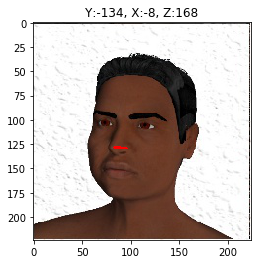

In [21]:
# 读取图像
img0 = cv2.imread('man.jpg')
img = img0[:, :, ::-1]  # 必须为 ::-1
# 获取7个特征点
landmark7 = get_landmark7(img)
# 计算旋转矩阵、平移矩阵、相机内参、畸变参数
success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs = get_rot_trans(img.shape, landmark7[1])
# 计算欧拉角姿势
img_with_line, pitch, yaw, roll = pose_estimation(img, img.shape)
# 显示
plt.imshow(img_with_line)
plt.title('Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll))
plt.show()

In [207]:
# 训练集
# 每个样本点有3个分量 (x0,x1,x2)
x = [(1, 0., 3), (1, 1., 3), (1, 2., 3), (1, 3., 2), (1, 4., 4)]
# y[i] 样本点对应的输出
y = [95.364, 97.217205, 75.195834, 60.105519, 49.342380]
 
# 迭代阀值，当两次迭代损失函数之差小于该阀值时停止迭代
epsilon = 0.0001
 
# 学习率
alpha = 0.01
diff = [0, 0]
max_itor = 1000
error1 = 0
error0 = 0
cnt = 0
m = len(x)
 
 
# 初始化参数
theta0 = 0
theta1 = 0
theta2 = 0
 
while True:
    cnt += 1
 
    # 参数迭代计算
    for i in range(m):
        # 拟合函数为 y = theta0 * x[0] + theta1 * x[1] +theta2 * x[2]
        # 计算残差
        diff[0] = (theta0 + theta1 * x[i][1] + theta2 * x[i][2]) - y[i]
 
        # 梯度 = diff[0] * x[i][j]
        theta0 -= alpha * diff[0] * x[i][0]
        theta1 -= alpha * diff[0] * x[i][1]
        theta2 -= alpha * diff[0] * x[i][2]
 
    # 计算损失函数
    error1 = 0
    for lp in range(len(x)):
        error1 += (y[lp]-(theta0 + theta1 * x[lp][1] + theta2 * x[lp][2]))**2/2
 
    if abs(error1-error0) < epsilon:
        break
    else:
        error0 = error1
 
    print (' theta0 : %f, theta1 : %f, theta2 : %f, error1 : %f' % (theta0, theta1, theta2, error1))
print ('Done: theta0 : %f, theta1 : %f, theta2 : %f' % (theta0, theta1, theta2))
print ('迭代次数: %d' % cnt)

 theta0 : 2.782632, theta1 : 3.207850, theta2 : 7.998823, error1 : 5997.941160
 theta0 : 4.254302, theta1 : 3.809652, theta2 : 11.972218, error1 : 3688.116951
 theta0 : 5.154766, theta1 : 3.351648, theta2 : 14.188535, error1 : 2889.123934
 theta0 : 5.800348, theta1 : 2.489862, theta2 : 15.617995, error1 : 2490.307286
 theta0 : 6.326710, theta1 : 1.500854, theta2 : 16.676947, error1 : 2228.380594
 theta0 : 6.792409, theta1 : 0.499552, theta2 : 17.545335, error1 : 2028.776801
 theta0 : 7.223066, theta1 : -0.467855, theta2 : 18.302105, error1 : 1865.563114
 theta0 : 7.630213, theta1 : -1.384304, theta2 : 18.982980, error1 : 1727.680635
 theta0 : 8.019329, theta1 : -2.244977, theta2 : 19.605108, error1 : 1609.405390
 theta0 : 8.393277, theta1 : -3.050113, theta2 : 20.177586, error1 : 1507.205260
 theta0 : 8.753766, theta1 : -3.801955, theta2 : 20.705955, error1 : 1418.574162
 theta0 : 9.101980, theta1 : -4.503454, theta2 : 21.194131, error1 : 1341.560444
 theta0 : 9.438851, theta1 : -5.157

 theta0 : 69.068038, theta1 : -13.563130, theta2 : 10.436166, error1 : 153.533722
 theta0 : 69.130493, theta1 : -13.562392, theta2 : 10.416342, error1 : 153.129860
 theta0 : 69.192814, theta1 : -13.561655, theta2 : 10.396561, error1 : 152.727728
 theta0 : 69.255001, theta1 : -13.560919, theta2 : 10.376823, error1 : 152.327317
 theta0 : 69.317053, theta1 : -13.560186, theta2 : 10.357127, error1 : 151.928622
 theta0 : 69.378972, theta1 : -13.559453, theta2 : 10.337473, error1 : 151.531634
 theta0 : 69.440757, theta1 : -13.558723, theta2 : 10.317862, error1 : 151.136345
 theta0 : 69.502409, theta1 : -13.557994, theta2 : 10.298293, error1 : 150.742750
 theta0 : 69.563929, theta1 : -13.557266, theta2 : 10.278766, error1 : 150.350840
 theta0 : 69.625315, theta1 : -13.556540, theta2 : 10.259282, error1 : 149.960608
 theta0 : 69.686569, theta1 : -13.555816, theta2 : 10.239839, error1 : 149.572046
 theta0 : 69.747692, theta1 : -13.555093, theta2 : 10.220439, error1 : 149.185149
 theta0 : 69.808

 theta0 : 97.502864, theta1 : -13.226889, theta2 : 1.410734, error1 : 58.768564
 theta0 : 97.504021, theta1 : -13.226875, theta2 : 1.410367, error1 : 58.768342
 theta0 : 97.505176, theta1 : -13.226862, theta2 : 1.410000, error1 : 58.768120
 theta0 : 97.506329, theta1 : -13.226848, theta2 : 1.409634, error1 : 58.767899
 theta0 : 97.507479, theta1 : -13.226835, theta2 : 1.409269, error1 : 58.767679
 theta0 : 97.508627, theta1 : -13.226821, theta2 : 1.408905, error1 : 58.767460
 theta0 : 97.509772, theta1 : -13.226807, theta2 : 1.408541, error1 : 58.767242
 theta0 : 97.510915, theta1 : -13.226794, theta2 : 1.408179, error1 : 58.767024
 theta0 : 97.512055, theta1 : -13.226781, theta2 : 1.407817, error1 : 58.766807
 theta0 : 97.513193, theta1 : -13.226767, theta2 : 1.407456, error1 : 58.766591
 theta0 : 97.514328, theta1 : -13.226754, theta2 : 1.407095, error1 : 58.766376
 theta0 : 97.515461, theta1 : -13.226740, theta2 : 1.406736, error1 : 58.766161
 theta0 : 97.516591, theta1 : -13.226727